# Setup

In [0]:
!pip install easy-vqa>=1.0

In [0]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from easy_vqa import get_train_questions, get_test_questions
from keras.preprocessing.text import Tokenizer
from easy_vqa import get_train_questions, get_test_questions, get_answers
from easy_vqa import get_train_image_paths, get_test_image_paths
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Multiply

In [0]:
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)

user_id = 0

PROJECT_LOC = ""

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Chirag
PROJECT_LOC = '/content/drive/My Drive/IIITD_Course/Sem_6/DL/DL_Group/Project_Easy_VQA'
os.chdir('/content/drive/My Drive/IIITD_Course/Sem_6/DL/DL_Group/Project_Easy_VQA')

In [0]:
# Prakhar
PROJECT_LOC = '/content/drive/My Drive/DL_Group/Project_Easy_VQA'
os.chdir('/content/drive/My Drive/DL_Group/Project_Easy_VQA')

In [0]:
# Akash
PROJECT_LOC = '/content/drive/My Drive/DL/Project_Easy_VQA'
# os.chdir('/content/drive/My Drive/DL/Project_Easy_VQA')

# Models

In [0]:
# The CNN
im_input = Input(shape=(64, 64, 3))  
x1 = Conv2D(8, 3, padding='same')(im_input)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(16, 3, padding='same')(x1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)
# Add a final fully-connected layer after the CNN for good measure
x1 = Dense(32, activation='tanh')(x1)

In [0]:
# Read questions
# train_qs and test_qs are just arrays of question strings
# (we'll use the other variables later)
train_qs, _, _ = get_train_questions()
test_qs, _, _ = get_test_questions()

# Fit tokenizer on the training questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qs)

# Convert questions to BOW
train_X_seqs = tokenizer.texts_to_matrix(train_qs)
test_X_seqs = tokenizer.texts_to_matrix(test_qs)

# We add one because the Keras Tokenizer reserves index 0 and never uses it.
vocab_size = len(tokenizer.word_index) + 1

# The question network
q_input = Input(shape=(vocab_size,))
x2 = Dense(32, activation='tanh')(q_input)
x2 = Dense(32, activation='tanh')(x2)


# Data Fetching

In [0]:
# Read question data
# (we already did this in the BOW section, remember?)
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()

# Read answer data
all_answers = get_answers()
num_answers = len(all_answers)

In [0]:
def load_and_proccess_image(image_path):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  im = img_to_array(load_img(image_path))
  return im / 255 - 0.5

def read_images(paths):
  # paths is a dict mapping image ID to image path
  # Returns a dict mapping image ID to the processed image
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path)
  return ims

train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())

In [0]:
# Create model input images
train_X_ims = [train_ims[id] for id in train_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

# Create model outputs
train_answer_indices = [all_answers.index(a) for a in train_answers]
test_answer_indices = [all_answers.index(a) for a in test_answers]
train_Y = to_categorical(train_answer_indices)
test_Y = to_categorical(test_answer_indices)

# Training

In [0]:
out = Multiply()([x1, x2]) # from previous section
out = Dense(32, activation='tanh')(out)
# num_answers will be defined below
out = Dense(num_answers, activation='softmax')(out)

model = Model(inputs=[im_input, q_input], outputs=out)
model.compile(
  Adam(lr=2e-4), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 8)    224         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 16)   1168        max_pooling2d_5[0][0]            
____________________________________________________________________________________________

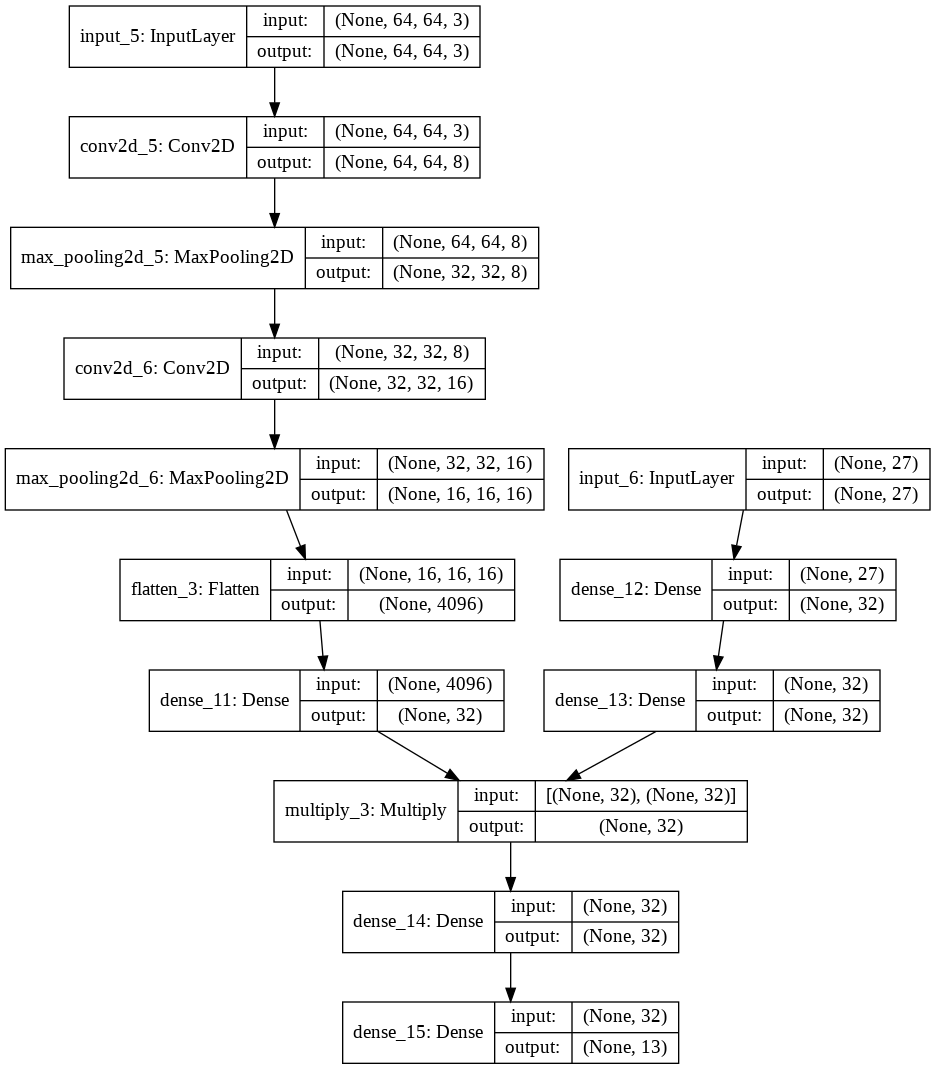

In [0]:
plot_model(model, show_shapes=True)

In [0]:
# Train the model!
history = model.fit(
  # Reminder: train_X_seqs is from this post's BOW section
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=10,
)

Train on 38575 samples, validate on 9673 samples
Epoch 1/10
38575/38575 [==============================] - 8s 203us/step - loss: 1.0513 - accuracy: 0.6204 - val_loss: 0.7972 - val_accuracy: 0.6729
Epoch 2/10
38575/38575 [==============================] - 8s 198us/step - loss: 0.7825 - accuracy: 0.6629 - val_loss: 0.7578 - val_accuracy: 0.6708
Epoch 3/10
38575/38575 [==============================] - 8s 197us/step - loss: 0.7614 - accuracy: 0.6633 - val_loss: 0.7433 - val_accuracy: 0.6848
Epoch 4/10
38575/38575 [==============================] - 8s 197us/step - loss: 0.7269 - accuracy: 0.6928 - val_loss: 0.6896 - val_accuracy: 0.7066
Epoch 5/10
38575/38575 [==============================] - 8s 198us/step - loss: 0.6634 - accuracy: 0.7219 - val_loss: 0.6301 - val_accuracy: 0.7380
Epoch 6/10
38575/38575 [==============================] - 8s 201us/step - loss: 0.6106 - accuracy: 0.7495 - val_loss: 0.5838 - val_accuracy: 0.7678
Epoch 7/10
38575/38575 [==============================] - 8s 19

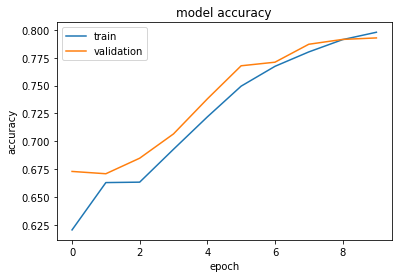

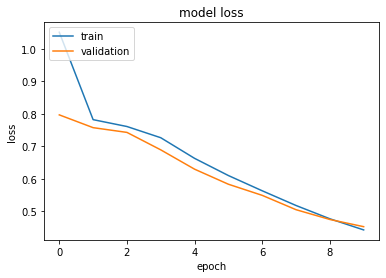

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
model.save('Data/baseline.h5')